In [1]:
library(CytoTRACE)

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.




In [2]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
library(Seurat)

In [4]:
getwd()

[1] "/home/tsubosaka/integrated_data/論文用再検討/修正"

In [5]:
setwd('/home/tsubosaka/integrated_data/論文用再検討/修正')

In [6]:
epi <- readRDS('./data_2_2_seurat_epi_annotated.rds') # input = epithelial cells' seurat objects

# 一応確認

In [10]:
data <- GetAssayData(object = epi[,1:20], slot = "data")

orig_exp <- exp(data) - 1

colSums(as.matrix(orig_exp))[1:20]

Stanford_5846N1-total_AAACCTGCAATGGATA Stanford_5846N1-total_AAAGATGGTTCCACAA 
                                 10000                                  10000 
Stanford_5846N1-total_AAATGCCGTTCACCTC Stanford_5846N1-total_AAATGCCTCTATCCCG 
                                 10000                                  10000 
Stanford_5846N1-total_AACTCCCAGCATCATC Stanford_5846N1-total_AACTGGTCAGCTGTAT 
                                 10000                                  10000 
Stanford_5846N1-total_AAGCCGCTCGGAAATA Stanford_5846N1-total_AAGGAGCAGATAGGAG 
                                 10000                                  10000 
Stanford_5846N1-total_AAGGAGCGTTCGGCAC Stanford_5846N1-total_AAGGAGCTCGGATGGA 
                                 10000                                  10000 
Stanford_5846N1-total_ACACCGGGTTCCAACA Stanford_5846N1-total_ACAGCTACAAGTAATG 
                                 10000                                  10000 
Stanford_5846N1-total_ACGATACAGACGCACA Stanford_5846N1-total_ACGCCAGAGCCACCTG 
                                 10000                                  10000 
Stanford_5846N1-total_ACTATCTAGACAGGCT Stanford_5846N1-total_ACTGAACCAGTTAACC 
                                 10000                                  10000 
Stanford_5846N1-total_ACTGAGTCACCATGTA Stanford_5846N1-total_ACTGATGTCTCGAGTA 
                                 10000                                  10000 
Stanford_5846N1-total_ACTGCTCCACTCTGTC Stanford_5846N1-total_ACTGTCCTCCAGTAGT 
                                 10000                                  10000

# OK

In [7]:
expr <- epi@assays$RNA@counts # raw matrix
expr <- as.data.frame(expr)

In [8]:
dat <- function(seurat_object, sample_name){
    s <- subset(seurat_object, idents=sample_name)
    s <- as.data.frame(s@assays$RNA@counts)
    return (s)
}

In [9]:
1+1

[1] 2

In [11]:
dataset <- c()

In [12]:
# dataset integration as list
Idents(epi) <- 'orig.ident'
for (i in 1:length(unique(epi$orig.ident))){
    dataset <- c(dataset, list(dat(epi,unique(epi$orig.ident)[i])))
}

In [13]:
length(dataset)

[1] 52

In [14]:
# perform CytoTRACE
results <- iCytoTRACE(dataset)

The number of cells in your dataset exceeds 10,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 39 sub-sample(s) of approximately 1004 cells each using 1 / 1 core(s)

Calculating genes associated with iCytoTRACE...



In [15]:
# construct phenodata (celltype labels)
unique_ident <- epi@meta.data$orig.ident %>% unique
phenodata <- c()

for(i in 1:length(unique(epi@meta.data$orig.ident))){
    s <- subset(epi, idents=unique_ident[i])
    s2 <- as.character(s@meta.data$subcluster)
    phenodata <- c(phenodata, s2)
}

In [16]:
names(phenodata) <- names(results$Counts)

In [17]:
options(repr.plot.width=7*3, repr.plot.height=7)

file saved to ./CytoTRACE_plot.pdf



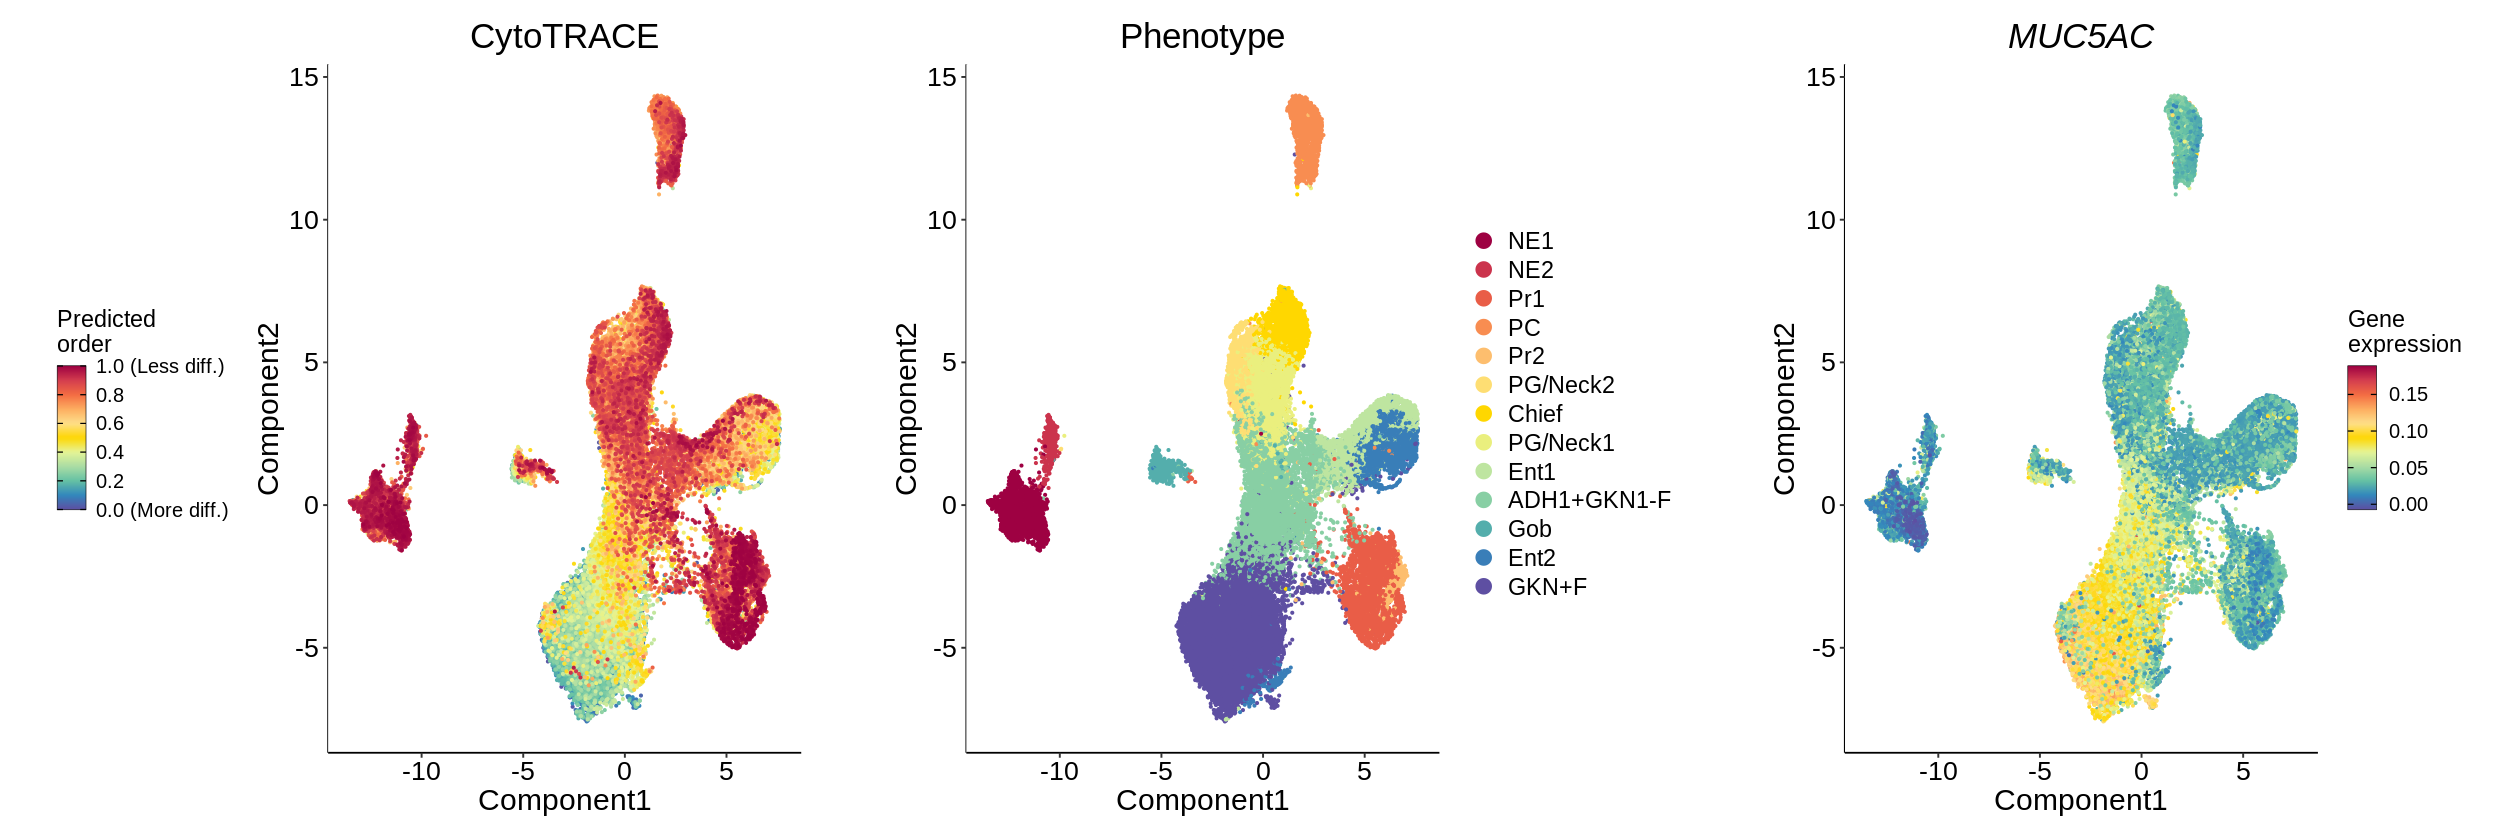

In [18]:
# plot the CytoTRACE
#options(repr.plot.width=30, repr.plot.height=20)
p1 <- plotCytoTRACE(results, phenotype = phenodata, gene = "MUC5AC",
                    emb = epi@reductions$umap@cell.embeddings,)

In [19]:
# save the important genes
plotCytoGenes(results, numOfGenes = 20)

png 
  2

# いまここまで

In [20]:
# preparation for ggplot2
dat2 <- as.data.frame(results$CytoTRACE)
dat2 <- cbind(dat2, epi@meta.data$subcluster)
dat2 <- cbind(dat2, results$GCS)

In [21]:
library(ggplot2)

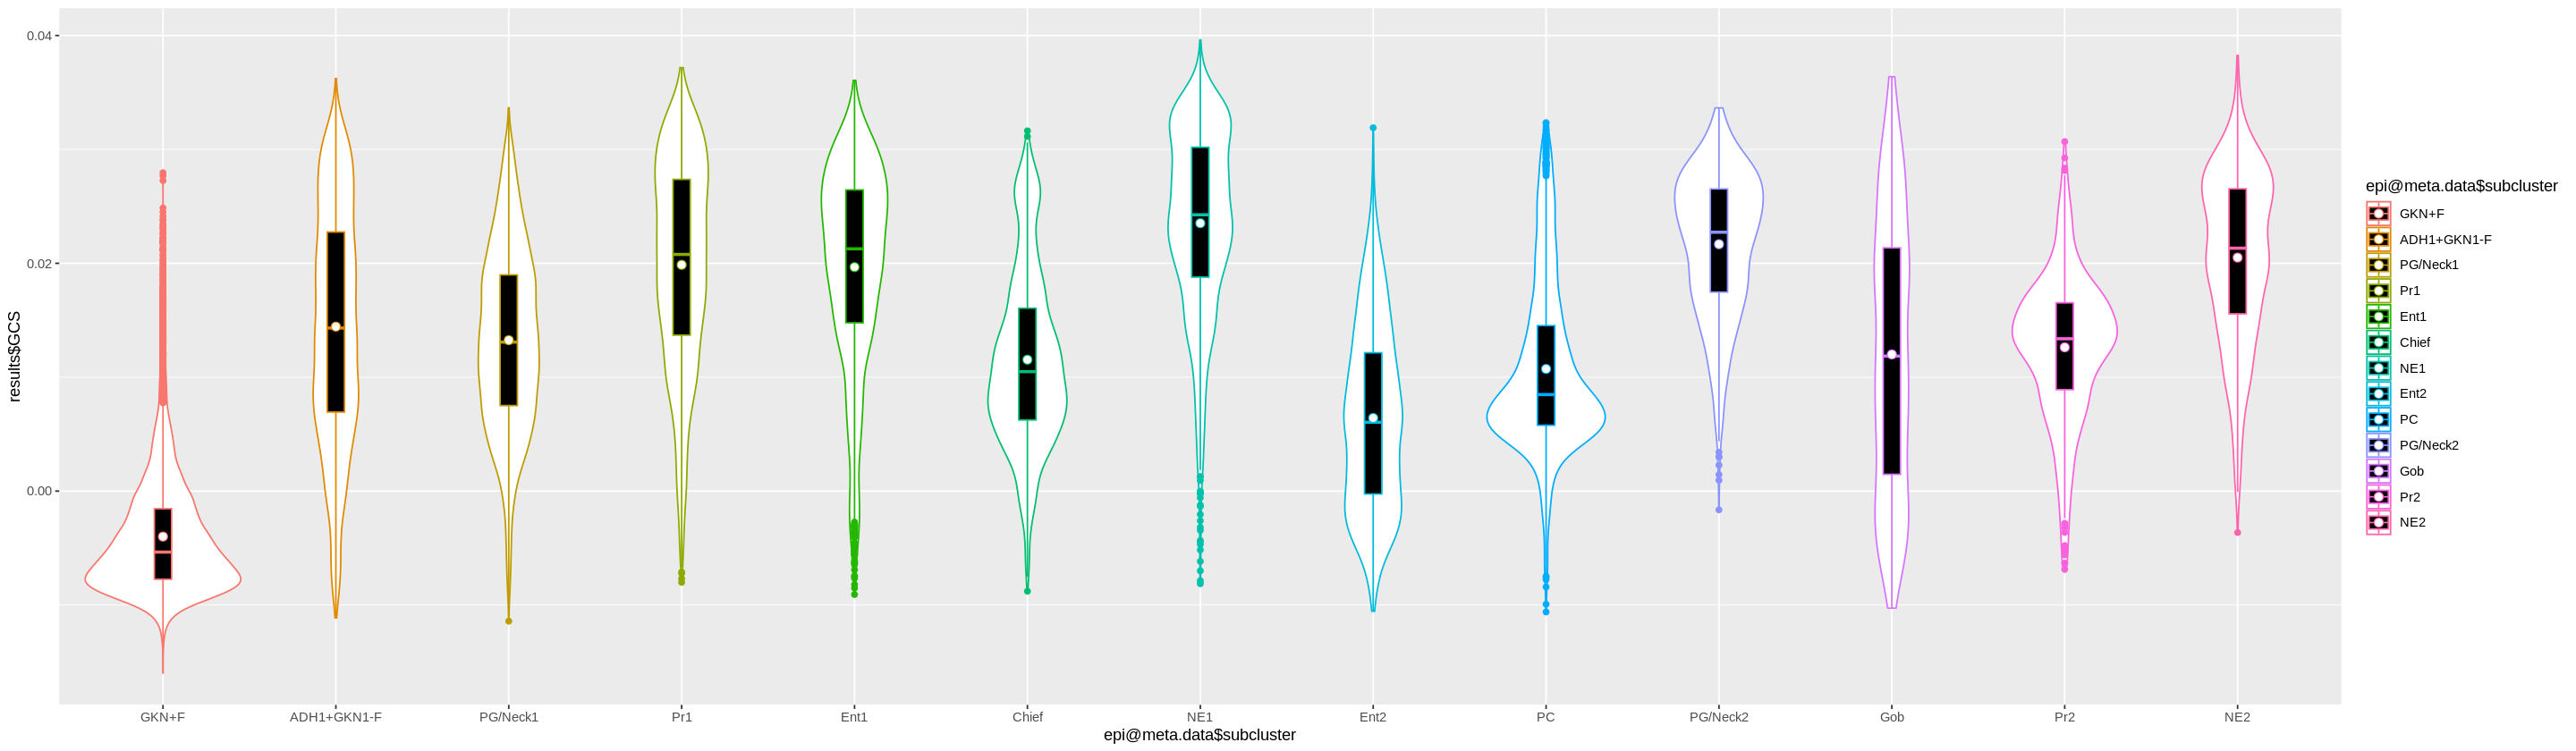

In [26]:
# plot the violin plot
options(repr.plot.width=24, repr.plot.height=7)
p <- ggplot(dat2,aes(x=results$GCS, y=epi@meta.data$subcluster, colour=epi@meta.data$subcluster))
p+geom_violin()+geom_boxplot(width=.1,fill="black")+stat_summary(fun=mean,geom = "point", fill="white",shape=21,size=2.5)+ coord_flip()

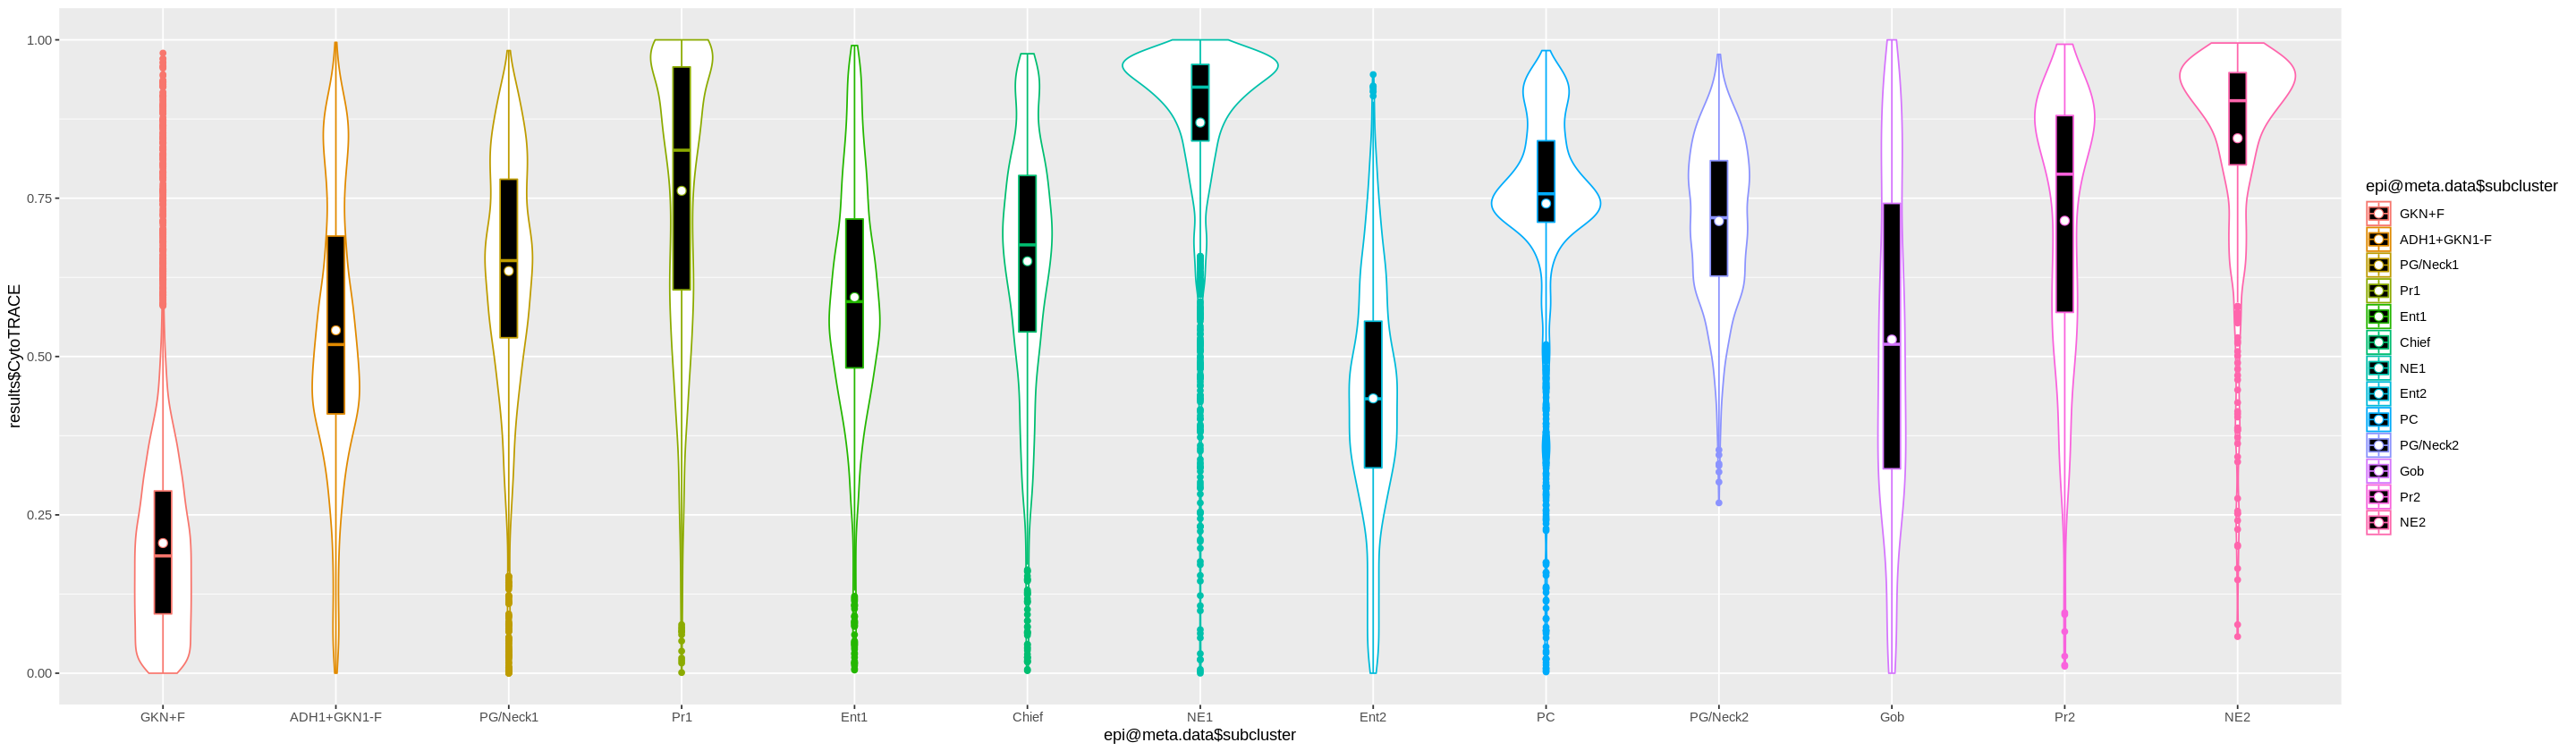

In [23]:
# plot the violin plot
options(repr.plot.width=24, repr.plot.height=7)
p <- ggplot(dat2,aes(x=results$CytoTRACE, y=epi@meta.data$subcluster, colour=epi@meta.data$subcluster))
p+geom_violin()+geom_boxplot(width=.1,fill="black")+stat_summary(fun=mean,geom = "point", fill="white",shape=21,size=2.5)+ coord_flip()


In [24]:
epi@meta.data['GCS'] <- results$GCS
epi@meta.data['CytoTRACE'] <- results$CytoTRACE
epi@meta.data['CytoTRACE_Rank'] <- results$CytoTRACErank

saveRDS(epi,'data_3_1_epi_cytotrace.rds')

In [42]:
epi

An object of class Seurat 
33538 features across 40754 samples within 1 assay 
Active assay: RNA (33538 features, 4000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

In [41]:
1+1

[1] 2

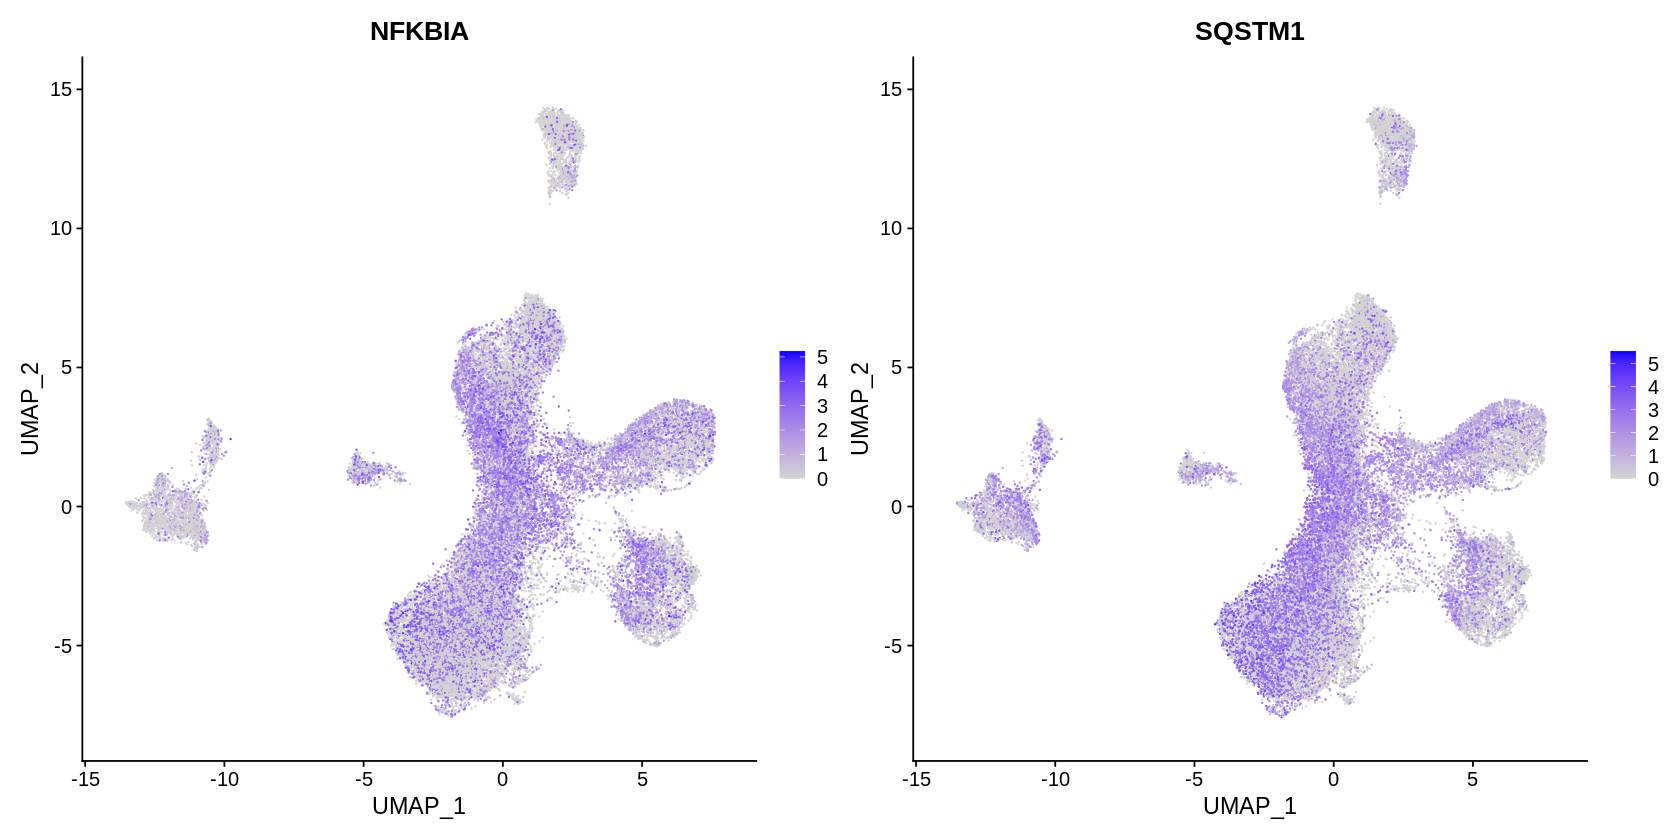

In [25]:
options(repr.plot.width=14, repr.plot.height=7)
FeaturePlot(epi,features=c('NFKBIA','SQSTM1'))